## Data Acquisition

For this project we used data from: 
- 2019 ACS 5 year variables 
- Los Angeles Building Permits
- Craigslist rental listings. 

The data acquisition stage took a particularly long time due to challenges with web scraping craigslist listings and circumnavigating anti-scraping measures. 

In [5]:
from sodapy import Socrata
import requests 
from requests import get
import pandas as pd
import geopandas as gpd
import json
import cenpy
from cenpy import products
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
from scipy import ndimage
import random import time

### Census Data
We aquired census data through the Cenpy package and pulled the following variables:
- Median Household Income
- Population
    - Total Population
    - White 
    - Black or African American
    - American Indian or Alaskan Native
    - Asian 
    - Hawaiian or Pacific Islander
    - Other
- Education
    - Total
    - Bachelor Degree
    - Masters Degree
    - Professional Degree
    - Doctoral Degree

We then calculated percentages for the various population statistics to serve as our primary variables. 

The next step was to clip census tracks to the City of LA boundry. Since everything else we use is by LA City we decided it was necessary to clip based on this boundry. We did not adjust our variables because there we assumed that are few census tracts where the distribution within the census tract is varried enough to make a significant impact in our estimates, and our variables had already been converted into shares. Below you can find an example of of a clipped map showing the percentage of non hispanic white residents.

Further details on how this data was pulled and cleaned, as well as some first exploratory maps can be found in our repository's [Census data](Census%20data.ipynb) notebook.

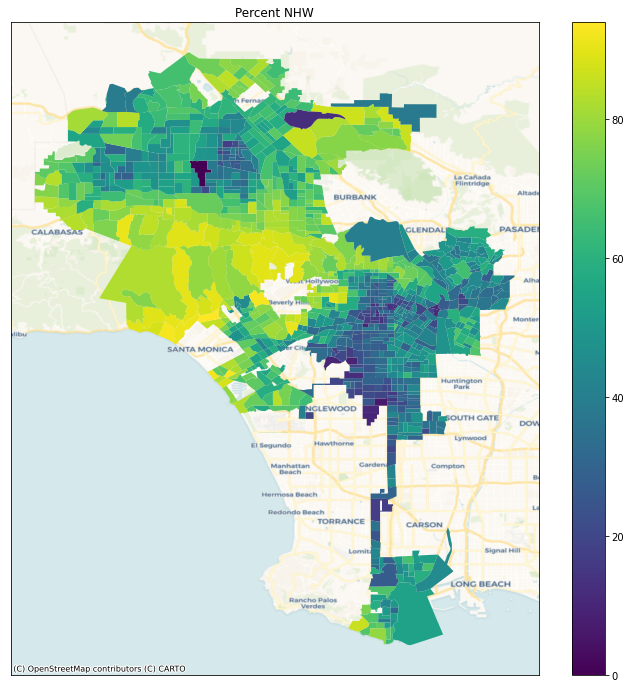

In [11]:
census_gdf = gpd.read_file('Data/CensusPlusPermits.geojson', crs='EPSG:4326') # pull in exported data from previous files.

fig, ax = plt.subplots(figsize=(12, 12))
census_gdf.plot('PctNHW', ax = ax, legend=True)

# remove the tick labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Percent NHW')
ctx.add_basemap(ax, crs=census_gdf.crs.to_string(), source=ctx.providers.CartoDB.Voyager)

### Permit Data
We pulled building permit data from the city of L.A.'s building permit dataset and specifically pulled permits for new construction to limit the data set, after a brief exploration with the basic socrata API we switched to using the Sodapy package to build a more direct query. Details on this process can be found in the [Permit Data Acquisition](Permit%20Data%20Acquisition.ipynb) Notebook.

Below you will also find a map of permit hotspots in L.A. 

In [4]:
permit_gdf = gpd.read_file('Data/permit_gdf.geojson', crs='EPSG:4326')

In [6]:
# Heatmap adapted from: https://nbviewer.org/gist/perrygeo/c426355e40037c452434

def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet', alpha=.3, title='title'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]
        # functions to return list of x and y coordinates
    
    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins) # places x and y points into bins 
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    fig, ax = plt.subplots(figsize=(12,12))
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent, alpha=alpha, zorder=15) 
    # controls coloring and details of map including drawing order (necessary for avoiding conflicts with the basemap)
    ctx.add_basemap(ax, crs=d.crs.to_string())
    ax.set_title(title, fontsize=18)
    plt.colorbar()
    plt.gca().invert_yaxis()
    
    plt.show()

/var/folders/kz/8hthyz657tlbhl0x92mmdj2r0000gn/T/ipykernel_37875/1774482244.py:15: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
/var/folders/kz/8hthyz657tlbhl0x92mmdj2r0000gn/T/ipykernel_37875/1774482244.py:17: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')


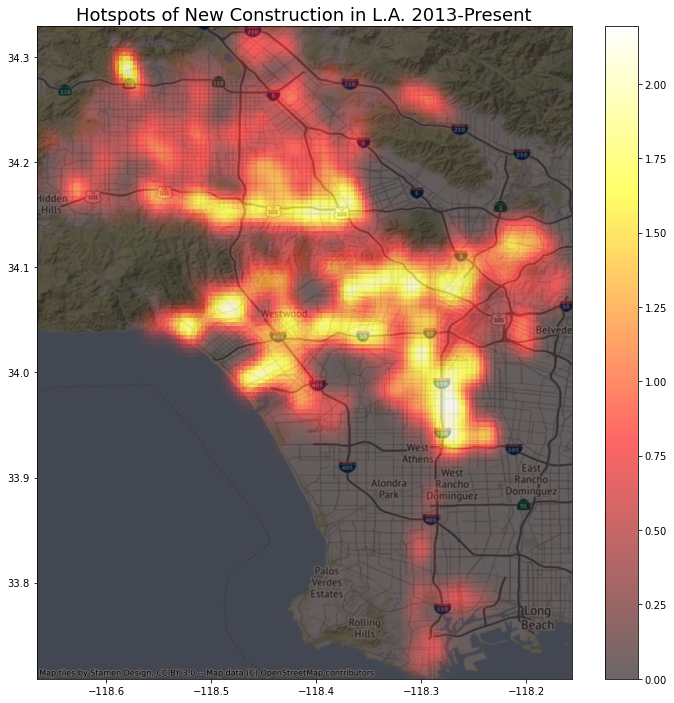

In [7]:
heatmap(permit_gdf, bins=(150,150), smoothing=2, cmap='hot', alpha=.6, title='Hotspots of New Construction in L.A. 2013-Present')

### Craigslist Scraping

Scraping the listings from craigslist was by far the most challenging and time consuming portion of this project. It was particularly challenging at first to loop over the pages of craigslist listings without having our IP addresses temporarily blocked. Once we developed a system to pull pages of craigslist data we also needed to pull point data for each listing, which was time consuming. Craigslist also organizes listings based upon five areas of L.A. (Long Beach, Central L.A., San Fernando Valley, San Gabriel Valley, and the West Side). We devided the areas between ourselves and ran the process to pull listings and geometry before joining them together to save time.

The listings and geometry that we pulled for were all pulled between May 22nd and 25th.

#### Scraping Listings

To scrape the craigslist listings we need to get the number of listings for the area of L.A. and loop over each page of listings. A complete notebook with exploratory pulls and checks for unique listings can be found in the [la_apt_scrape](la_apt_scrape.ipynb) notebook.

In [6]:
#pull a first page of listings to later find the number of listings available 
response = get('https://losangeles.craigslist.org/search/lgb/apa') 

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

In [7]:
from time import sleep
import re
from random import randint #avoid throttling by not sending too many requests one after the other and randomizing the time between calls
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

#each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []

for page in pages:
    
    #get request
    response = get("https://losangeles.craigslist.org/search/lgb/apa?" 
                   + "s=" #the parameter for defining the page number 
                   + str(page) #the page number in the pages array from earlier
#                    + "&hasPic=1"
#                    + "&availabilityMode=0"
                  )

    sleep(randint(1,5))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = page_html.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:

        if post.find('span', class_ = 'result-hood') is not None:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
            post_price = post.a.text.strip().replace("$", "")
            post_prices.append(post_price)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    bedroom_counts.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
                
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")


#loading posts into a data frame
lgb_apts = pd.DataFrame({'posted': post_timing,
                       'neighborhood': post_hoods,
                       'post title': post_title_texts,
                       'number bedrooms': bedroom_counts,
                        'sqft': sqfts,
                        'URL': post_links,
                       'price': post_prices})
lgb_apts.head()

/var/folders/kz/8hthyz657tlbhl0x92mmdj2r0000gn/T/ipykernel_40651/3574052943.py:6: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output


Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!
Page 6 scraped successfully!
Page 7 scraped successfully!
Page 8 scraped successfully!
Page 9 scraped successfully!
Page 10 scraped successfully!
Page 11 scraped successfully!
Page 12 scraped successfully!
Page 13 scraped successfully!
Page 14 scraped successfully!
Page 15 scraped successfully!
Page 16 scraped successfully!
Page 17 scraped successfully!
Page 18 scraped successfully!
Page 19 scraped successfully!
Page 20 scraped successfully!
Page 21 scraped successfully!


Scrape complete!


,posted,neighborhood,post title,number bedrooms,sqft,URL,price
0,2022-06-01 19:27,(long beach / 562),"1/BD, Courtyard views, Located in Long Beach",1,656.0,https://losangeles.craigslist.org/lgb/apa/d/lo...,"2,572"
1,2022-06-01 18:53,(Downey),Downey 1 Bedroom 1 Bath W/ Air Conditioning + ...,1,610.0,https://losangeles.craigslist.org/lgb/apa/d/do...,"1,750"
2,2022-06-01 18:53,(long beach / 562),1 BEDROOM 1 BATHROOM MOVE IN NOW! CALL FOR DET...,1,700.0,https://losangeles.craigslist.org/lgb/apa/d/no...,"1,891"
3,2022-06-01 18:50,(long beach / 562),"1/BD, Zen garden and sundeck, Resident social ...",1,656.0,https://losangeles.craigslist.org/lgb/apa/d/lo...,"2,447"
4,2022-06-01 18:38,(Long Beach),Ceiling Fan(s) | Gas Range | 1 Bedroom 1 BA i...,1,500.0,https://losangeles.craigslist.org/lgb/apa/d/lo...,"1,325"


#### Geometry Scraping

We tested the methodology for retrieving lat_long coordinates seperately to avoid making too many calls to craigs list. When we found a successful method we had to build a similar randomized sleep timer into our function avoid being blocked by craigslist. The resulting function took about two hours to run for every 3000 listings, which is why we split it up between individual group members to run for individual sections of L.A.

We have not run the function in this notebook and instead are only providing examples of code due to the length of time it takes to run. 

The full method can be found in the [Lat_Long](Lat_Long.ipynb) notebook.

In [8]:
def get_latlong(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.content)
    try:
        link = soup.find_all('div', class_='viewposting') #where the geometry is consistently located in the listings
        
        #lat and long are contained within a dictionary within a list, these extract the data.
        lat = link[0]['data-latitude'] 
        long = link[0]['data-longitude']
        
        #this randomizes the time between calls to craigslist and slow down the scraper and avoid being blocked.
        time.sleep(random.uniform(.5,3))  
    
        return [lat, long]
    except:
        return [None, None] #return none if error from searching for lat/long or if the page is no longer available

We then applied this function along the URL to return a column named `latlon` that contains a list of `[y,x]` and created x and y columns with the values from this list:

`df['y'] = df['latlon'].apply(lambda x: x[0])` 

`df['x'] = df['latlon'].apply(lambda x: x[1])`